# Image segmentation

In this pytorch experiment, I develop and train a convolutional neural network for brain tumour image segmentation.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The notebook is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.


In [91]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-02-26 10:03:10--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-02-26 10:03:11--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd2851e79bbb86224674a6cc6db.dl.dropboxusercontent.com/cd/0/inline/B3PawJDfV-F_kZZSU7xj3If3oQwzH48bdc8OXSaJwVl_jn7imMT2OVZ_ImFEc3Et-v8evfxbsKh0U65Ar7JfLEjstnCU5HKUebTaX8Ag6GAhRQr7aad9OPX6CDdLGoTWO38RY91FexvV_yaZ4sWGbr2HvAeThCV53vTUqk6MtYvlWQ/file# [following]
--2023-02-26 10:03:11--  https://ucd2851e79bbb86224674a6cc6db.dl.dropboxusercontent.com/cd/0/inline/B3PawJDfV-F_kZZSU7xj3If3oQwzH48b

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

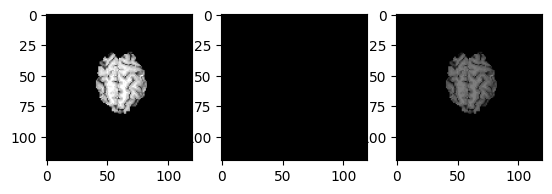

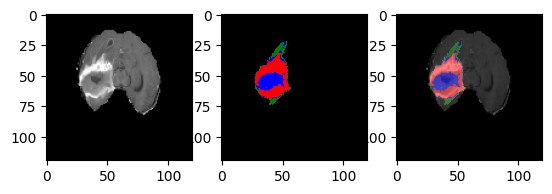

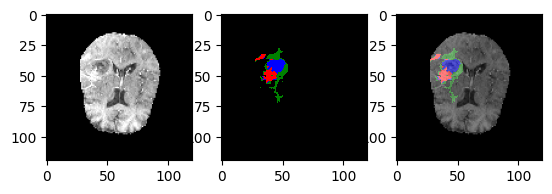

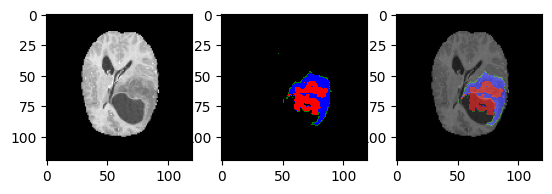

In [92]:
# Visualise a random set of 4 training images along with their label maps.
no_of_random_images = 4
train_image_path = 'coursework_02/Task01_BrainTumour_2D/training_images'
train_label_path = 'coursework_02/Task01_BrainTumour_2D/training_labels'

# note training image names and label names are the same
training_image_names = os.listdir(train_image_path)

random_training_image_names = random.sample(training_image_names, no_of_random_images)

for random_training_image in random_training_image_names:
    image = imageio.imread(os.path.join(train_image_path, random_training_image))
    label = imageio.imread(os.path.join(train_label_path, random_training_image))

    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(label, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    ax[2].imshow(label, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    # overlap the label map on the image
    ax[2].imshow(image, cmap='gray', alpha=0.5)
    plt.show()

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [5]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        batch_images, batch_labels = [], []

        random_indices = random.sample(range(self.__len__()), batch_size)
        for random_index in random_indices:
            image, label = self.__getitem__(random_index)
            batch_images.append(image)
            batch_labels.append(label)

        #expects numpy array
        batch_images = np.array(batch_images)
        # extend dimension to match torch input dimension (i.e C = 1, iH =120, iW = 120)
        batch_images = np.expand_dims(batch_images, axis=1) # N, C, H, W
        batch_labels = np.array(batch_labels)
        return batch_images, batch_labels

## 3. Build a U-net architecture.

I implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters.

In [ ]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            # Note: stride=2 is what causes the image dimensions to halve
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        n = int(n/2) # 64
        self.upconv4 = nn.Sequential(
            # Use ConvTranspose2d to upsample the feature map (make layer x*y output bigger)
            # upconv4: 128 -> 64 , kernel size = 2 !!
            nn.ConvTranspose2d(n*2, n, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n/2) # 32
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(n*2, n, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n/2) # 16
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(n*2, n, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )


        self.conv8 = nn.Sequential(
            nn.Conv2d(n, output_channel, kernel_size=1),
        )



    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)
        # Decoder

        x = self.upconv4(x)
        x = self.conv5(torch.cat((x, conv3_skip), dim=1))

        x = self.upconv3(x)
        x = self.conv6(torch.cat((x, conv2_skip), dim=1))

        x = self.upconv2(x)
        x = self.conv7(torch.cat((x, conv1_skip), dim=1))

        x = self.conv8(x)

        return x

## 4. Train the segmentation model.

In [29]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    loss = criterion(logits, labels)
    # prevent gradient accumulation from previous iterations which can lead to incorrect updates
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
            logits = model(test_images)
            loss = criterion(logits, test_labels)
            print('Iter {0}: test loss = {1:.3f}, time = {2:.3f}s'.format(it, loss, time.time() - start_iter))
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
Iter 100: test loss = 0.643, time = 0.058s
Iter 200: test loss = 0.265, time = 0.060s
Iter 300: test loss = 0.139, time = 0.058s
Iter 400: test loss = 0.112, time = 0.046s
Iter 500: test loss = 0.101, time = 0.061s
Iter 600: test loss = 0.136, time = 0.056s
Iter 700: test loss = 0.061, time = 0.062s
Iter 800: test loss = 0.058, time = 0.062s
Iter 900: test loss = 0.035, time = 0.062s
Iter 1000: test loss = 0.045, time = 0.064s
Iter 1100: test loss = 0.053, time = 0.064s
Iter 1200: test loss = 0.041, time = 0.060s
Iter 1300: test loss = 0.047, time = 0.064s
Iter 1400: test loss = 0.045, time = 0.063s
Iter 1500: test loss = 0.042, time = 0.065s
Iter 1600: test loss = 0.054, time = 0.064s
Iter 1700: test loss = 0.039, time = 0.064s
Iter 1800: test loss = 0.024, time = 0.067s
Iter 1900: test loss = 0.042, time = 0.061s
Iter 2000: test loss = 0.032, time = 0.065s
Iter 2100: test loss = 0.037, time = 0.064s
Iter 2200: test loss = 0.031, time = 0.059s
Iter 2300: test loss = 0.038

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

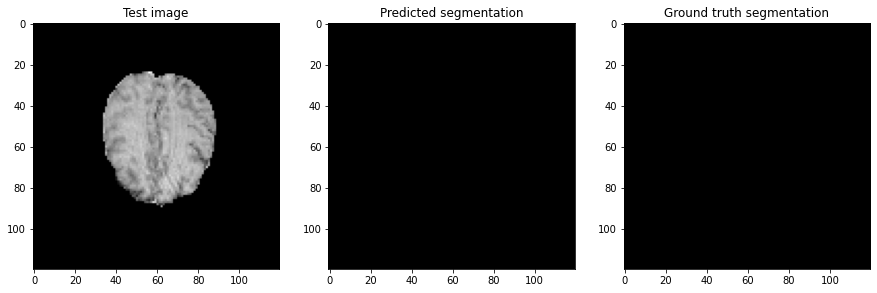

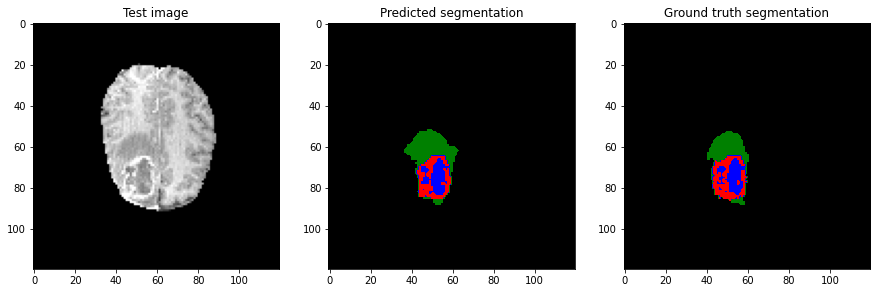

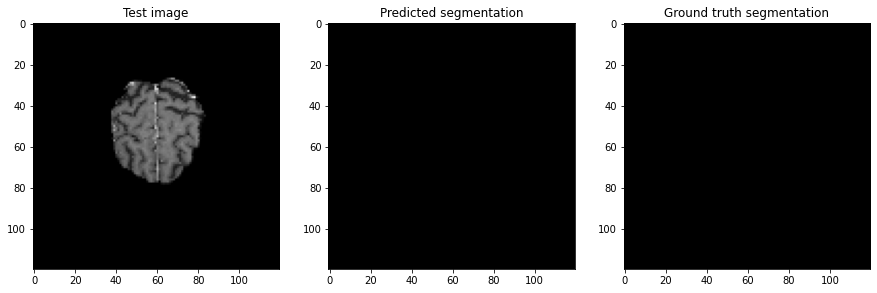

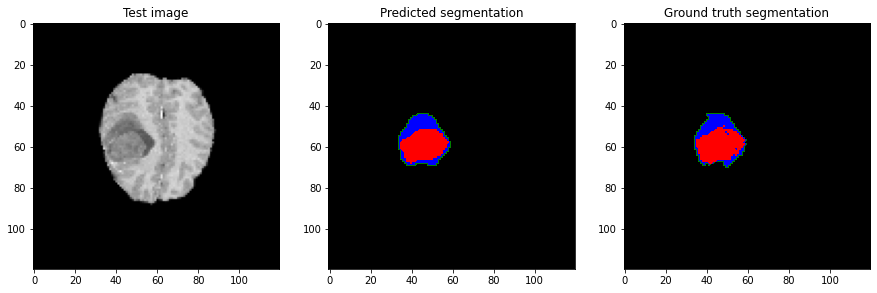

In [31]:
### Insert your code ###
no_of_test_images = 4
test_images, test_labels = test_set.get_random_batch(no_of_test_images)
test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

path = os.path.join(model_dir,'model_10000.pt')
model.load_state_dict(torch.load(path))
model.eval()

logits = model(test_images)

for i in range(no_of_test_images):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title('Test image')
    plt.subplot(1, 3, 2)
    plt.imshow(logits[i, :, :, :].argmax(dim=0).cpu().numpy(), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    plt.title('Predicted segmentation')
    plt.subplot(1, 3, 3)
    plt.imshow(test_labels[i, :, :].cpu().numpy(), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    plt.title('Ground truth segmentation')
    plt.show()

### End of your code ###

## 6. Evaluation Does the trained model work well? How would one improve this model so it can be deployed to the real clinic?

The trained model works well because it does not create any false positive segmentations, which is especially important as false positives can result in chemotherapy and other medical procedures, that have severe side-effects. In regard to the class of segmentation, the model is good at segmenting the various different types of medical conditions as can be seen by the close match of colours in predicted segmentation and ground truth segmentation. Finally, the locality of segmentation is to a good standard although not exact as we see areas which should be classified as a medical condition considered as background and vice versa.

To improve the model for a real clinic, we must improve how accurately we segment the pixels per class (i.e we should minimise the mis-classification as we are sometimes predicting background areas as having a condition.) To do this, we can augment the data through random cropping/ flipping/ etc. to help the network better localise by exposing it to more diverse input data and allowing it to learn more robust features. As we can see, we are broadly correct with the location of segments and general shape, however there are issues regarding the accuracy of boundaries (particularly the 2nd image from top). This can be improved by concating more local features with global features, perhaps in a layout more similiar to UNet++.

If we were to not change to UNet++ ,we can increase the depth and in turn no of skip connections, which will help the network capture more complex features but more importantly allows for earlier layers to be propagated further down the network, which will enable high level features to refine the boundaries of predictions.